# Spam Filter: Text Classification with uci enron dataset
### スパムメールフィルター

2019-01-05

![title](https://www.webdevelopersnotes.com/wp-content/uploads/gmail-spam-filter-how-it-works.png)

## 1. Inspecting the dataset データの調査

In [59]:
import numpy as np
import pandas as pd
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics, svm
from sklearn.model_selection import (
    train_test_split, learning_curve, StratifiedShuffleSplit, GridSearchCV,
    cross_val_score)

# Improve the readability of figures
sns.set_context('notebook', font_scale=1.4)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [9]:
os.chdir("/Users/akr712/Desktop/spam_filter_enron_dataset")
df = pd.read_table("SMSSpamCollection.txt", header=None)
df.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


データの詳細を一通り眺める

In [10]:
df.shape

(5572, 2)

In [17]:
df.columns = ["Target", "Text"]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
Target    5572 non-null object
Text      5572 non-null object
dtypes: object(2)
memory usage: 87.1+ KB


【メモ】
  「スパム」のデータ量は、「スパムではないメッセージ」のデータ量に比べてかなり少ない。

In [19]:
df["Target"].value_counts()

ham     4825
spam     747
Name: Target, dtype: int64

「スパム」と「スパムではないメッセージ」によく含まれる単語の違いをイメージできるようにする。

計算負荷を減らすため、目的変数となる"Target"列をバイナリに変換する

In [28]:
le = preprocessing.LabelEncoder()
y = le.fit_transform(df["Target"])

## 2. Text preprocessing - 前処理 - 

自然言語を特徴量に転換するために、数値情報に変える必要がある。   
自然言語処理では、元データとなる文章や単語をそのまま特徴量として使おうとすると、以下のデメリットが生じる。   
    
・説明変数が膨大になり学習に時間がかかる  
・過学習を起こしやすくなる    

### 2-1. Normalization - 単語の正規化 -    
    
大文字や小文字を揃える

![text](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTp7ERA8pYIVb6Afzvihd0G75GIPX4q5nAJMw3fZBaFK19IihnnBw)

In [70]:
text_exapmple = df.iloc[0]["Text"]
text_exapmple

'Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...'

まず、本文とは関係がない文字列や頻出する記号や単語を排除する。  
「メールアドレス」、「URL」、「$」、「電話番号」など。

In [41]:
raw_text = df["Text"]
processed = raw_text.str.replace(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b',
                                 'emailaddr')
processed = processed.str.replace(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)',
                                  'httpaddr')
processed = processed.str.replace(r'£|\$', 'moneysymb')    
processed = processed.str.replace(
    r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
    'phonenumbr')    
processed = processed.str.replace(r'\d+(\.\d+)?', 'numbr')

In [42]:
# "today"と"today?"を揃える
processed = processed.str.replace(r'[^\w\d\s]', ' ')
processed = processed.str.replace(r'\s+', ' ')
processed = processed.str.replace(r'^\s+|\s+?$', '')

In [50]:
# 全て小文字にする
processed = processed.str.lower()

### 2-2. Stop words - ストップワードの削除 -

頻出するものの、文章の特徴を表す訳ではない単語をストップワードとして、特徴から外してしまう。   
例としては、"when"や"had"などが含まれる。   
基本的にはコーパスと呼ばれる各言語ごとの文脈を含んだ辞書にストップワードリストがまとめられている。   

In [61]:
stop_words = nltk.corpus.stopwords.words('english')
processed = processed.apply(lambda x: ' '.join(
    term for term in x.split() if term not in set(stop_words)))

### 2-3. Stemming - 語幹による単語の統一化 -  
    

語形の変化を取り除き、同一の単語表現に変換する処理のこと。   
例えば、「run」というクエリで検索をした場合でもrunnerやrunningなどのキーワードとマッチングさせること。

In [65]:
porter = nltk.PorterStemmer()
processed = processed.apply(lambda x: ' '.join(porter.stem(term) for term in x.split()))

In [64]:
def preprocess_text(messy_string):
    assert(type(messy_string) == str)
    cleaned = re.sub(r'\b[\w\-.]+?@\w+?\.\w{2,4}\b', 'emailaddr', messy_string)
    cleaned = re.sub(r'(http[s]?\S+)|(\w+\.[A-Za-z]{2,4}\S*)', 'httpaddr',
                     cleaned)
    cleaned = re.sub(r'£|\$', 'moneysymb', cleaned)
    cleaned = re.sub(
        r'\b(\+\d{1,2}\s)?\d?[\-(.]?\d{3}\)?[\s.-]?\d{3}[\s.-]?\d{4}\b',
        'phonenumbr', cleaned)
    cleaned = re.sub(r'\d+(\.\d+)?', 'numbr', cleaned)
    cleaned = re.sub(r'[^\w\d\s]', ' ', cleaned)
    cleaned = re.sub(r'\s+', ' ', cleaned)
    cleaned = re.sub(r'^\s+|\s+?$', '', cleaned.lower())
    return ' '.join(
        porter.stem(term) 
        for term in cleaned.split()
        if term not in set(stop_words)
    )

In [72]:
(processed == raw_text.apply(preprocess_text)).all()

False

In [71]:
preprocess_text(text_exapmple)

'go jurong point crazi avail bugi n great world la e buffet cine got amor wat'

## 3. Feature engineering - 特徴量生成 -

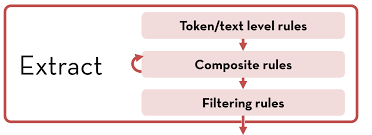

### 3-1. Tokenization - トークン化（単語分解） -

文書をトークンに分解すること。一般的にトークナイズには以下の2種類がある。   
   
・形態素解析   
・N-gram   
    
★トークナイズの例：「東京都と神奈川県」

#### 形態素解析
東京/都/と/神奈川/県

#### N-gram
東京/京都/都と/と神/神奈/奈川/川県

### 3-2. Term Frequency and Inverse Document Frequency (TF-IDF) - 重要単語評価 -

### 3-3. Wrod Vectrization - 単語のベクトル化（次元表現）-

In [74]:
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_ngrams = vectorizer.fit_transform(processed)
X_ngrams.shape

(5572, 36323)

## 4. Training and evaluating a model

## 5. What terms are the top predictors of spam?

## 6. How to improve the model